# 0. Install Dependencies and Bring in Data

In [2]:
!pip install tensorflow pandas matplotlib scikit-learn

In [3]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [4]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
df.iloc[1000]['comment_text']

"Rex Mundi \r\n\r\nI've created a stub on Rex Mundi at Rex Mundi High School.  Only thing I know about it is that both my Aunt Donna and Bob Griese went there.  Please add anything you might know about it.\r\n\r\nBTW, my dad was a Panther; I live in Princeton myself."

In [7]:
df[df.columns[2:]].iloc[1000]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 1000, dtype: int64

In [8]:
df[df['severe_toxic']==1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
181,006e87872c8b370c,you are a stupid fuck \r\n\r\nand your mother'...,1,1,1,0,1,0
442,01208d2b76624130,Hi \r\n\r\nIm a fucking bitch.\r\n\r\n50.180.2...,1,1,1,0,1,0
579,018663f910e0bfe6,What a motherfucking piece of crap those fuckh...,1,1,1,0,1,0


# 1. Preprocess

In [9]:
!pip list

Package                           Version
--------------------------------- ------------
absl-py                           2.1.0
aiobotocore                       2.7.0
aiofiles                          23.2.1
aiohttp                           3.9.3
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.12
altair                            5.0.1
anaconda-anon-usage               0.4.3
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.1.4
anaconda-navigator                2.5.2
anaconda-project                  0.11.1
annotated-types                   0.6.0
anyio                             4.2.0
appdirs                           1.4.4
archspec                          0.2.1
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
astroid                           2.14.2
astropy                 

In [10]:
from tensorflow.keras.layers import TextVectorization

In [11]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [12]:
MAX_FEATURES = 200000 # number of words in the vocab

In [13]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [14]:
TextVectorization??

Init signature:
TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding='utf-8',
    name=None,
    **kwargs,
)
Source:        
@keras_export("keras.layers.TextVectorization")
class TextVectorization(Layer):
    """A preprocessing layer which maps text features to integer sequences.

    This layer has basic options for managing text in a Keras model. It
    transforms a batch of strings (one example = one string) into either a list
    of token indices (one example = 1D tensor of integer token indices) or a
    dense representation (one example = 1D tensor of float values representing
    data about the example's tokens). This layer is meant to handle natural
    language inputs. To handle simple string inputs (categorical strings or
    pr

In [15]:
vectorizer.adapt(X.values)

In [16]:
print(vectorizer)

<TextVectorization name=text_vectorization, built=False>


In [17]:
vectorized_text = vectorizer(X.values)

In [18]:
#MCSHBAP - map, cache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [19]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [20]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding

In [22]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [23]:
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer='Adam')

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 ━━━━━━━━━━━━━━━━━━━━ 3193s 456ms/step - loss: 0.0854 - val_loss: 0.0488


In [26]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

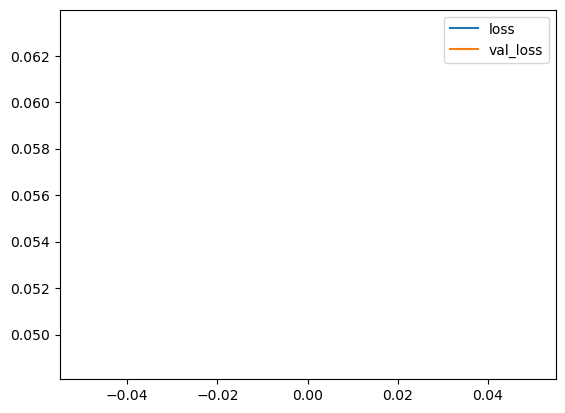

In [27]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [28]:
input_text = vectorizer("I hate you. You don't deserve this.")

In [29]:
res = model.predict(np.expand_dims(input_text,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


In [30]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [31]:
print(res)

[[0.7124425  0.01873139 0.2909789  0.03862228 0.30906388 0.05957133]]


In [32]:
(res > 0.5).astype(int)

array([[1, 0, 0, 0, 0, 0]])

In [33]:
batch=test.as_numpy_iterator().next()

In [34]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [35]:
model.predict(batch_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step


array([[8.21458995e-01, 4.55094837e-02, 4.73072708e-01, 4.90873978e-02,
        4.25762475e-01, 9.49197263e-02],
       [4.40839026e-03, 3.80653518e-08, 1.28928776e-04, 1.73754324e-05,
        8.09751364e-05, 1.26305686e-05],
       [1.67281702e-02, 1.48064578e-06, 8.63880210e-04, 1.70380954e-04,
        6.57460070e-04, 1.37457231e-04],
       [7.01361522e-02, 3.67016110e-05, 5.37252054e-03, 1.56886177e-03,
        5.59080252e-03, 1.23177178e-03],
       [1.00517713e-01, 1.01690421e-04, 1.02156587e-02, 3.40516632e-03,
        1.12534454e-02, 2.53326376e-03],
       [1.66876777e-03, 8.21028667e-09, 4.85502242e-05, 5.07097866e-06,
        2.29420766e-05, 3.87994623e-06],
       [1.10818878e-01, 1.14460025e-04, 1.05179707e-02, 3.67652415e-03,
        1.24610430e-02, 2.70793657e-03],
       [5.48025686e-03, 1.13824996e-07, 2.05828721e-04, 2.99885687e-05,
        1.26872459e-04, 2.39408328e-05],
       [3.18699032e-01, 1.37526938e-03, 4.63107377e-02, 1.44980056e-02,
        6.66379258e-02, 

In [36]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [37]:
res.shape

(1, 6)

# 4. Evaluate Model

In [38]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [39]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [40]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━

In [41]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9027384519577026, Recall:0.5458178520202637, Accuracy:0.48846539855003357


# 5. Test and Gradio

In [42]:
# serialize model to JSON
# model_json = model.to_json()

In [43]:
# with open("modelepoch5.json", "w") as json_file:
#     json_file.write(model_json)

In [44]:
# from tensorflow.keras.models import model_from_json
# model_architecture=model_from_json(model_json)

In [45]:
# model_architecture.summary()

In [46]:
# serialize weights to HDF5
# model.save_weights("modelepoch5.weights.h5")

In [47]:
model.save('C:/Atharva_coding/ml/CommentToxicity/output_1/toxicity_epoch1.keras')

In [48]:
reconstructed_model = tf.keras.models.load_model('C:/Atharva_coding/ml/CommentToxicity/output_1/toxicity_epoch1.keras')

c:\Users\athar\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 32 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


ValueError: A total of 1 objects could not be loaded. Example error message for object <LSTMCell name=lstm_cell, built=True>:

Layer 'lstm_cell' expected 3 variables, but received 0 variables during loading. Expected: ['kernel', 'recurrent_kernel', 'bias']

List of objects that could not be loaded:
[<LSTMCell name=lstm_cell, built=True>]

In [70]:
input_str = vectorizer('I love you.')

In [71]:
print(input_str)

tf.Tensor([  8 457   7 ...   0   0   0], shape=(1800,), dtype=int64)


In [72]:
res = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


In [73]:
res

array([[7.35102966e-03, 3.35792588e-10, 1.05806634e-04, 3.73521543e-05,
        9.22994295e-05, 2.90483586e-04]], dtype=float32)

In [52]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    print(vectorized_comment)
    results = model_architecture.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx])
    new_df = pd.DataFrame(columns=df.columns[2:], data=results)
    print(new_df.head)
    return results

In [1]:
score_comment('Men are good people')

NameError: name 'score_comment' is not defined

In [54]:
!pip install gradio jinja2

In [55]:
import gradio as gr

In [56]:
interface = gr.Interface(fn=score_comment, inputs="textbox", outputs='text')

In [57]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://3c3c8e6e265c5e4b1e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [58]:
interface.close()

Closing server running on port: 7860
